In [ ]:
!pip install imdbpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from imdb import Cinemagoer
import requests

API_KEY = '46e15202f799196825e9aa6ece4f1964'

In [ ]:
def cast_directors(title):
  ia = Cinemagoer()
  movie=ia.search_movie(title.lower())
  movie=movie[0]
  movie_details = ia.get_movie(movie.movieID)
  if 'casting director' in movie_details:
    cast_dir = movie_details['casting director']
    if cast_dir:
      print(cast_dir[0])
      return str(cast_dir[0])
  return 'not available'

cast_directors('black panther')

In [ ]:
def movie_id_getter(title):
  ia = Cinemagoer()
  movie=ia.search_movie(title.lower())
  movie=movie[0]
  print(movie.movieID)
  if(movie.movieID):
    return movie.movieID
  return -1

In [ ]:
df=pd.read_csv(r'/content/drive/MyDrive/imdb_top_1000.csv')
df

In [ ]:
df['Casting Director']=df['Series_Title'].apply(cast_directors)

In [ ]:
df.to_csv('/content/sample_data/imdb_top_1000_with_casting.csv', index=False)

In [ ]:
df=pd.read_csv(r'/content/sample_data/imdb_top_1000_with_casting.csv')
df

In [ ]:
import threading
import pandas as pd
import math
import time
import random

threads = []
num_threads = 50
chunk_size = math.ceil(len(df) / num_threads)

def process_chunk(start, end):
    chunk = df['Series_Title'][start:end]
    movie_ids = []

    for title in chunk:
        attempts = 0
        success = False
        while attempts < 3 and not success:
            try:
                movie_id = movie_id_getter(title)
                movie_ids.append(movie_id)
                success = True
            except Exception as e:
                attempts += 1
                print(f"Error getting Movie ID for '{title}': {e}. Attempt {attempts}/3.")
                time.sleep(random.uniform(1, 3))

        if not success:
            movie_ids.append(None)

    df.loc[start:end - 1, 'IMDb_id'] = movie_ids


for i in range(num_threads):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(df))
    if start < len(df):
        thread = threading.Thread(target=process_chunk, args=(start, end))
        threads.append(thread)
        thread.start()


for thread in threads:
    thread.join()

print("Processing complete.")


In [ ]:
df['IMDb_id']

In [ ]:
df

In [ ]:
import pandas as pd
import requests
import threading


def find_tmdb_and_details_by_imdb(imdb_id, api_key):
    url = f'https://api.themoviedb.org/3/find/tt{imdb_id}?api_key={api_key}&external_source=imdb_id'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data['movie_results']:
                tmdb_id = data['movie_results'][0]['id']
                print(f"TMDb ID for IMDb ID {imdb_id}: {tmdb_id}")

                movie_details_url = f'https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={api_key}'
                details_response = requests.get(movie_details_url)
                if details_response.status_code == 200:
                    details_data = details_response.json()
                    budget = details_data.get('budget', 'Unknown')
                    revenue = details_data.get('revenue', 'Unknown')
                    print(f"Budget: {budget}, Revenue: {revenue}")
                    return tmdb_id, budget, revenue
                else:
                    print(f"Error fetching movie details: {details_response.status_code}")
                    return tmdb_id, None, None
            else:
                print(f"No TMDb results found for IMDb ID {imdb_id}")
                return None, None, None
        else:
            print(f"Error fetching TMDb data: HTTP {response.status_code}")
            return None, None, None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

df['TMDB_ID'] = None
df['Budget'] = None
df['Revenue'] = None


def update_movie_details(index, imdb_id):
    tmdb_id, budget, revenue = find_tmdb_and_details_by_imdb(imdb_id, API_KEY)
    df.at[index, 'TMDB_ID'] = tmdb_id
    df.at[index, 'Budget'] = budget
    df.at[index, 'Revenue'] = revenue

threads = []


for index, row in df.iterrows():
    imdb_id = row['IMDb_id']
    thread = threading.Thread(target=update_movie_details, args=(index, imdb_id))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()


In [ ]:
df

In [ ]:
print(len(df[df['IMDb_id'].isna()]))
print(len(df[df['TMDB_ID'].isna()]))
print(len(df[df['Budget'].isna()]))
print(len(df[df['Revenue'].isna()]))
print(len(df[df['Casting Director']=="not available"]))

In [ ]:
from imdb import IMDb
import pandas as pd

ia = IMDb()

def fetch_movie_data(imdb_id):
    try:
        movie = ia.get_movie(imdb_id)
        budget = movie.get('box office', {}).get('Budget', 'N/A')
        revenue = movie.get('box office', {}).get('Cumulative Worldwide Gross', 'N/A')
        return budget, revenue
    except Exception as e:
        print(f"Error fetching data for IMDb ID {imdb_id}: {e}")
        return 'N/A', 'N/A'


for index, row in df.iterrows():
    if pd.isnull(row['Budget']) or pd.isnull(row['Revenue']):
        imdb_id = row['IMDb_id']
        if not pd.isnull(imdb_id):
            budget, revenue = fetch_movie_data(int(imdb_id))
            df.at[index, 'Budget'] = budget
            df.at[index, 'Revenue'] = revenue


In [ ]:
df

In [ ]:
print(len(df[df['IMDb_id'].isna()]))
print(len(df[df['TMDB_ID'].isna()]))
print(len(df[df['Budget'].isna()]))
print(len(df[df['Revenue'].isna()]))
print(len(df[df['Casting Director']=="not available"]))

In [ ]:
import numpy as np


def generate_random_budget_and_revenue():
    budget = np.random.randint(1000000, 400000000)
    revenue = np.random.randint(0.6 * budget, 2 * budget)
    return budget, revenue

for index, row in df.iterrows():
    if pd.isnull(row['Budget']) or row['Budget'] == 0 or row['Budget'] == 'N/A' or pd.isnull(row['Revenue']) or row['Revenue'] == 0 or row['Revenue'] == 'N/A':
        budget, revenue = generate_random_budget_and_revenue()
        df.at[index, 'Budget'] = budget
        df.at[index, 'Revenue'] = revenue

In [ ]:
df

In [ ]:
print(len(df[df['IMDb_id'].isna()]))
print(len(df[df['TMDB_ID'].isna()]))
print(len(df[df['Budget'].isna()]))
print(len(df[df['Revenue'].isna()]))
print(len(df[df['Casting Director']=="not available"]))

In [ ]:
df.to_csv("updated_dataset_with_random_values_asdfasdf.csv", index=False)

In [ ]:
def classify_movie(row):
    budget = row['Budget']
    revenue = row['Revenue']
    imdb_rating = row['IMDB_Rating']


    if revenue >= 1.5 * budget and imdb_rating >= 9.0:
        return 'Successful'

    elif revenue >= 2 * budget:
        return 'Successful'

    elif 1 * budget <= revenue < 1.5 * budget and imdb_rating >= 8.0:
        return 'Successful'

    elif revenue < budget and imdb_rating >= 7.0:
        return 'Unsuccessful'

    else:
        return 'Unsuccessful'

df['Movie_Success'] = df.apply(classify_movie, axis=1)


In [ ]:
df

In [ ]:
print(len(df[df['Movie_Success']=="Successful"]))
print(len(df[df['Movie_Success']=="Unsuccessful"]))

In [ ]:
df['Casting Director'] = df['Casting Director'].replace('not available', np.nan)

In [ ]:
df.to_csv("imdb_1000_final_dataset.csv", index=False)

DATASET DONE

In [ ]:
df = pd.read_csv('/content/sample_data/imdb_1000_final_dataset.csv')

In [ ]:
df

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for _, row in df.iterrows():

    people = [row['Director'], row['Star1'], row['Star2'], row['Star3'], row['Star4'], row['Casting Director']]

    for i in range(len(people)):
        for j in range(i + 1, len(people)):
            G.add_edge(people[i], people[j])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")
plt.title("Movie Collaboration Graph", size=15)
plt.show()


In [ ]:
nx.write_gml(G, 'movie_collaboration_graph.gml')

In [ ]:
G = nx.read_gml('/content/sample_data/movie_collaboration_graph.gml')

In [ ]:
import networkx as nx

average_clustering_coefficient = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {average_clustering_coefficient}")

In [ ]:
success_counts = df['Movie_Success'].value_counts()
print(success_counts)

success_percentage = success_counts / len(df) * 100
print(success_percentage)


In [ ]:
pip install node2vec

In [ ]:
from node2vec import Node2Vec
import numpy as np

node2vec = Node2Vec(G, dimensions=80, walk_length=10, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

node_embeddings = {node: model.wv[node] for node in G.nodes()}

embedding_cols = [f'embed_{i}' for i in range(80)]

embeddings_list = []

for _, row in df.iterrows():
    people = [row['Director'], row['Star1'], row['Star2'], row['Star3'], row['Star4'], row['Casting Director']]

    valid_embeddings = [node_embeddings[person] for person in people if person in node_embeddings]

    if valid_embeddings:
        movie_embedding = np.mean(valid_embeddings, axis=0)
    else:
        movie_embedding = np.zeros(80)
    embeddings_list.append(movie_embedding)

embeddings_df = pd.DataFrame(embeddings_list, columns=embedding_cols)
df_enhanced = pd.concat([df.reset_index(drop=True), embeddings_df], axis=1)


In [ ]:
import pandas as pd


embedding_df = pd.DataFrame(node_embeddings).T
embedding_df.columns = [f'dim_{i}' for i in range(80)]


embedding_df.to_csv('node2vec_embeddings.csv', index=True)


In [ ]:

model.wv.save_word2vec_format('movie_collaboration_embeddings.emb')

In [ ]:
embedding_df = pd.read_csv('/content/node2vec_embeddings.csv')

In [ ]:
df

In [ ]:
embedding_df

In [ ]:

embedding_df.set_index('Unnamed: 0', inplace=True)

print(embedding_df.head())


In [ ]:

movie_embeddings = []

for _, row in df.iterrows():
    people = [row['Director'], row['Star1'], row['Star2'], row['Star3'], row['Star4'], row['Casting Director']]


    valid_embeddings = [(embedding_df.loc[person].values) for person in people if person in embedding_df.index]


    if valid_embeddings:
        movie_embedding = np.mean((valid_embeddings), axis=0)
    else:


    movie_embeddings.append(movie_embedding)


movie_embeddings_df = pd.DataFrame(movie_embeddings, columns=[f'movie_embed_{i}' for i in range(80)])


df_final = pd.concat([df.reset_index(drop=True), movie_embeddings_df], axis=1)


In [ ]:
df_final.to_csv('movie_dataset_with_embeddings.csv', index=False)

In [ ]:
df_final.columns

Prediction


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

In [ ]:
G = nx.read_gml('/content/sample_data/movie_collaboration_graph.gml')

num_edges = G.number_of_edges()

num_nodes = G.number_of_nodes()

average_clustering = nx.average_clustering(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average clustering coefficient: {average_clustering}")


In [ ]:
df_original=pd.read_csv('/content/sample_data/imdb_1000_final_dataset.csv')
df_embedded=pd.read_csv('/content/sample_data/movie_dataset_with_embeddings.csv')

In [ ]:
df_original.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross',
       'Casting Director', 'IMDb_id', 'TMDB_ID', 'Budget', 'Revenue',
       'Movie_Success'],
      dtype='object')

In [ ]:
df_embedded.columns

Index(['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate',
       'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director',
       ...
       'movie_embed_70', 'movie_embed_71', 'movie_embed_72', 'movie_embed_73',
       'movie_embed_74', 'movie_embed_75', 'movie_embed_76', 'movie_embed_77',
       'movie_embed_78', 'movie_embed_79'],
      dtype='object', length=102)

In [ ]:
le = LabelEncoder()

In [ ]:
df_original = df_original.drop(columns=['Poster_Link', 'Series_Title', 'Genre', 'Overview'])


df_original['Movie_Success'] = le.fit_transform(df_original['Movie_Success'])


categorical_cols = df_original.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_original[col] = df_original[col].astype(str)
    df_original[col] = le.fit_transform(df_original[col])

df_original = df_original.fillna(df_original.mean())


X_og = df_original.drop(columns=['Movie_Success'])
y_og = df_original['Movie_Success']


X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X_og, y_og, test_size=0.2, random_state=42)

In [ ]:

df_embedded = df_embedded.drop(columns=['Poster_Link', 'Series_Title', 'Genre', 'Overview'])


df_embedded['Movie_Success'] = le.fit_transform(df_embedded['Movie_Success'])


categorical_cols = df_embedded.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_embedded[col] = df_embedded[col].astype(str)
    df_embedded[col] = le.fit_transform(df_embedded[col])


df_embedded = df_embedded.fillna(df_embedded.mean())


X_embed = df_embedded.drop(columns=['Movie_Success'])
y_embed = df_embedded['Movie_Success']


X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(X_embed, y_embed, test_size=0.2, random_state=42)

In [ ]:

random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
neural_network = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

In [ ]:
print("Results on Movie Dataset:")

# Random Forest
random_forest.fit(X_train_og, y_train_og)
y_pred_og_rf = random_forest.predict(X_test_og)
accuracy_og_rf = accuracy_score(y_test_og, y_pred_og_rf)
report_og_rf = classification_report(y_test_og, y_pred_og_rf)
print(f"\nModel: Random Forest")
print(f"Accuracy: {accuracy_og_rf:.4f}")
print(f"Classification Report:\n{report_og_rf}")

# Gradient Boosting
gradient_boosting.fit(X_train_og, y_train_og)
y_pred_og_gb = gradient_boosting.predict(X_test_og)
accuracy_og_gb = accuracy_score(y_test_og, y_pred_og_gb)
report_og_gb = classification_report(y_test_og, y_pred_og_gb)
print(f"\nModel: Gradient Boosting")
print(f"Accuracy: {accuracy_og_gb:.4f}")
print(f"Classification Report:\n{report_og_gb}")

# Decision Tree
decision_tree.fit(X_train_og, y_train_og)
y_pred_og_dt = decision_tree.predict(X_test_og)
accuracy_og_dt = accuracy_score(y_test_og, y_pred_og_dt)
report_og_dt = classification_report(y_test_og, y_pred_og_dt)
print(f"\nModel: Decision Tree")
print(f"Accuracy: {accuracy_og_dt:.4f}")
print(f"Classification Report:\n{report_og_dt}")

# Neural Network
neural_network.fit(X_train_og, y_train_og)
y_pred_og_nn = neural_network.predict(X_test_og)
accuracy_og_nn = accuracy_score(y_test_og, y_pred_og_nn)
report_og_nn = classification_report(y_test_og, y_pred_og_nn)
print(f"\nModel: Neural Network")
print(f"Accuracy: {accuracy_og_nn:.4f}")
print(f"Classification Report:\n{report_og_nn}")

Results on Movie Dataset:

Model: Random Forest
Accuracy: 0.8000
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69        70
           1       0.82      0.89      0.85       130

    accuracy                           0.80       200
   macro avg       0.79      0.76      0.77       200
weighted avg       0.80      0.80      0.80       200


Model: Gradient Boosting
Accuracy: 0.8150
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        70
           1       0.84      0.88      0.86       130

    accuracy                           0.81       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.81      0.81      0.81       200


Model: Decision Tree
Accuracy: 0.7600
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        70
           1       0.

In [ ]:
print("\nResults on Movie Dataset With embeddings:")

# Random Forest
random_forest.fit(X_train_embed, y_train_embed)
y_pred_embed_rf = random_forest.predict(X_test_embed)
accuracy_embed_rf = accuracy_score(y_test_embed, y_pred_embed_rf)
report_embed_rf = classification_report(y_test_embed, y_pred_embed_rf)
print(f"\nModel: Random Forest")
print(f"Accuracy: {accuracy_embed_rf:.4f}")
print(f"Classification Report:\n{report_embed_rf}")

# Gradient Boosting
gradient_boosting.fit(X_train_embed, y_train_embed)
y_pred_embed_gb = gradient_boosting.predict(X_test_embed)
accuracy_embed_gb = accuracy_score(y_test_embed, y_pred_embed_gb)
report_embed_gb = classification_report(y_test_embed, y_pred_embed_gb)
print(f"\nModel: Gradient Boosting")
print(f"Accuracy: {accuracy_embed_gb:.4f}")
print(f"Classification Report:\n{report_embed_gb}")

# Decision Tree
decision_tree.fit(X_train_embed, y_train_embed)
y_pred_embed_dt = decision_tree.predict(X_test_embed)
accuracy_embed_dt = accuracy_score(y_test_embed, y_pred_embed_dt)
report_embed_dt = classification_report(y_test_embed, y_pred_embed_dt)
print(f"\nModel: Decision Tree")
print(f"Accuracy: {accuracy_embed_dt:.4f}")
print(f"Classification Report:\n{report_embed_dt}")

# Neural Network
neural_network.fit(X_train_embed, y_train_embed)
y_pred_embed_nn = neural_network.predict(X_test_embed)
accuracy_embed_nn = accuracy_score(y_test_embed, y_pred_embed_nn)
report_embed_nn = classification_report(y_test_embed, y_pred_embed_nn)
print(f"\nModel: Neural Network")
print(f"Accuracy: {accuracy_embed_nn:.4f}")
print(f"Classification Report:\n{report_embed_nn}")


Results on Movie Dataset With embeddings:

Model: Random Forest
Accuracy: 0.7750
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.66        70
           1       0.81      0.86      0.83       130

    accuracy                           0.78       200
   macro avg       0.76      0.74      0.74       200
weighted avg       0.77      0.78      0.77       200


Model: Gradient Boosting
Accuracy: 0.8400
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.67      0.75        70
           1       0.84      0.93      0.88       130

    accuracy                           0.84       200
   macro avg       0.84      0.80      0.81       200
weighted avg       0.84      0.84      0.84       200


Model: Decision Tree
Accuracy: 0.7650
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.69      0.67        70
    

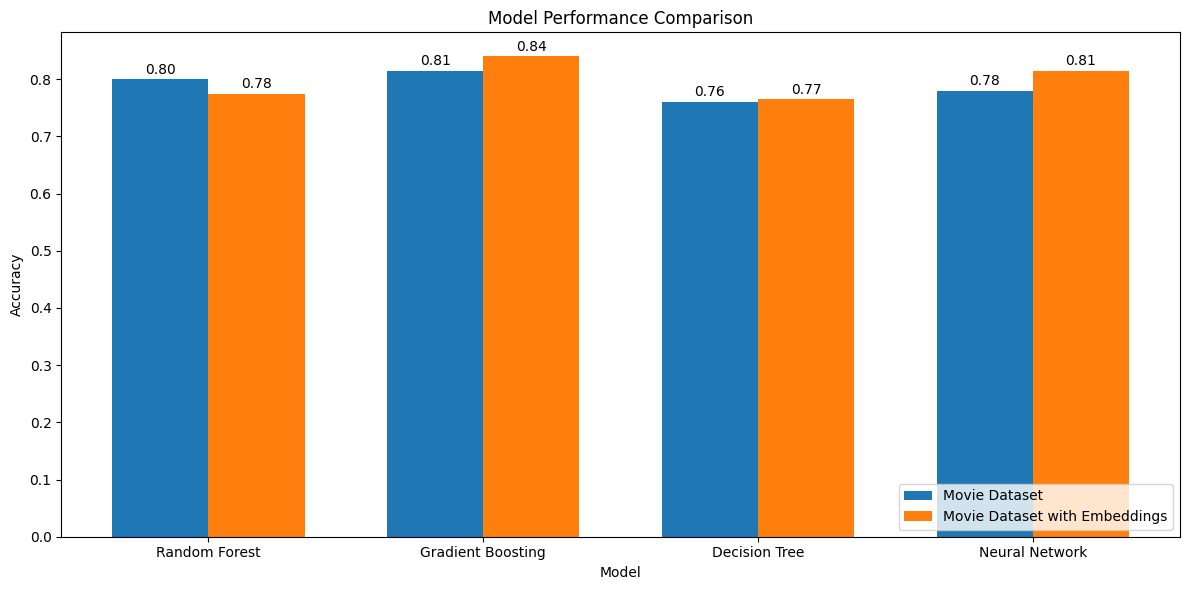

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'Neural Network']


accuracy_movie = [accuracy_og_rf, accuracy_og_gb, accuracy_og_dt, accuracy_og_nn]
accuracy_embed = [accuracy_embed_rf, accuracy_embed_gb, accuracy_embed_dt, accuracy_embed_nn]


fig, ax = plt.subplots(figsize=(12, 6))


bar_width = 0.35
index = np.arange(len(models))


bar1 = ax.bar(index, accuracy_movie, bar_width, label='Movie Dataset')
bar2 = ax.bar(index + bar_width, accuracy_embed, bar_width, label='Movie Dataset with Embeddings')


ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend(loc="lower right")

for i, v in enumerate(accuracy_movie):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center')

for i, v in enumerate(accuracy_embed):
    ax.text(i + bar_width, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

In [ ]:
models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'Neural Network']

percentage_gain = [
    ((embed - movie) / movie) * 100 if movie != 0 else 0
    for embed, movie in zip(accuracy_embed, accuracy_movie)
]

for model, gain in zip(models, percentage_gain):
    print(f"{model}: {gain:.2f}% gain in accuracy with embeddings")


Random Forest: -3.13% gain in accuracy with embeddings
Gradient Boosting: 3.07% gain in accuracy with embeddings
Decision Tree: 0.66% gain in accuracy with embeddings
Neural Network: 4.49% gain in accuracy with embeddings
